In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data/iciar/train/'
test_dir = "data/iciar/test/"

extracted_features_dir = "extracted_features/"
model_name = "iciar_densenet"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.10.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/iciar/train/ 0
data/iciar/train/carcinoma 2310
data/iciar/train/non-carcinoma 2310
******************************
data/iciar/test/ 0
data/iciar/test/carcinoma 50
data/iciar/test/non-carcinoma 50


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 3466 images belonging to 2 classes.
Found 1154 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 3466
nb_validation_samples: 1154

predict_size_train: 109
predict_size_validation: 37
nb_test_samples: 100
predict_size_test: 4

 num_classes: 2


In [9]:
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

# #     config = tf.ConfigProto()
# #     config.gpu_options.allow_growth = True
# #     set_session(tf.Session(config=config))


# reset_keras_tf_session()

In [11]:
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.densenet import DenseNet169
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile

input_tensor = Input(shape = input_shape)  
model = InceptionV3(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=input_tensor)
bottleneck_final_model = model

In [12]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [13]:
# c1 = model.layers[9].output 
# c1 = GlobalAveragePooling2D()(c1)       

# c2 = model.layers[55].output
# c2 = GlobalAveragePooling2D()(c2)       

# c3 = model.layers[143].output
# c3 = GlobalAveragePooling2D()(c3)       

# c4 = model.layers[483].output
# c4 = GlobalAveragePooling2D()(c4)

# con = concatenate([c1, c2, c3, c4])

# bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [17]:
# bottleneck_final_model.summary()

In [15]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [16]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [18]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [19]:
dropout_rate = 0.4

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.9, amsgrad=False)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 3466 samples, validate on 1154 samples
Epoch 1/1000
 - 4s - loss: 0.5972 - acc: 0.6878 - val_loss: 0.4251 - val_acc: 0.8163
Epoch 2/1000
 - 0s - loss: 0.4362 - acc: 0.7983 - val_loss: 0.3596 - val_acc: 0.8510
Epoch 3/1000
 - 0s - loss: 0.3492 - acc: 0.8557 - val_loss: 0.3156 - val_acc: 0.8648
Epoch 4/1000
 - 0s - loss: 0.2992 - acc: 0.8808 - val_loss: 0.2832 - val_acc: 0.8752
Epoch 5/1000
 - 0s - loss: 0.2632 - acc: 0.8996 - val_loss: 0.2809 - val_acc: 0.8839
Epoch 6/1000
 - 0s - loss: 0.2328 - acc: 0.9094 - val_loss: 0.2385 - val_acc: 0.9090
Epoch 7/1000
 - 0s - loss: 0.2015 - acc: 0.9299 - val_loss: 0.2232 - val_acc: 0.9107
Epoch 8/1000
 - 0s - loss: 0.1830 - acc: 0.9357 - val_loss: 0.2116 - val_acc: 0.9177
Epoch 9/1000
 - 0s - loss: 0.1632 - acc: 0.9403 - val_loss: 0.1971 - val_acc: 0.9194
Epoch 10/1000
 - 0s - loss: 0.1413 - acc: 0.9538 - val_loss: 0.2032 - val_acc: 0.9185
Epoch 11/1000
 - 0s - loss: 0.1322 - acc: 0.9564 - val_loss: 0.1756 - val_acc: 0.9333
Epoch 12/1000
 

Epoch 95/1000
 - 0s - loss: 1.9852e-04 - acc: 1.0000 - val_loss: 0.1385 - val_acc: 0.9593
Epoch 96/1000
 - 0s - loss: 2.2234e-04 - acc: 1.0000 - val_loss: 0.1394 - val_acc: 0.9584
Epoch 97/1000
 - 0s - loss: 1.3969e-04 - acc: 1.0000 - val_loss: 0.1354 - val_acc: 0.9688
Epoch 98/1000
 - 0s - loss: 1.4252e-04 - acc: 1.0000 - val_loss: 0.1456 - val_acc: 0.9619
Epoch 99/1000
 - 0s - loss: 1.4341e-04 - acc: 1.0000 - val_loss: 0.1308 - val_acc: 0.9653
Epoch 100/1000
 - 0s - loss: 1.8064e-04 - acc: 1.0000 - val_loss: 0.1470 - val_acc: 0.9627
Epoch 101/1000
 - 0s - loss: 2.0001e-04 - acc: 1.0000 - val_loss: 0.1329 - val_acc: 0.9645
Epoch 102/1000
 - 0s - loss: 1.0628e-04 - acc: 1.0000 - val_loss: 0.1335 - val_acc: 0.9645
Epoch 103/1000
 - 0s - loss: 7.7055e-05 - acc: 1.0000 - val_loss: 0.1392 - val_acc: 0.9619
Epoch 104/1000
 - 0s - loss: 1.6668e-04 - acc: 1.0000 - val_loss: 0.1371 - val_acc: 0.9601
Epoch 105/1000
 - 0s - loss: 5.0737e-04 - acc: 0.9997 - val_loss: 0.1343 - val_acc: 0.9619
Epoc

 - 0s - loss: 2.7177e-06 - acc: 1.0000 - val_loss: 0.1704 - val_acc: 0.9619
Epoch 186/1000
 - 0s - loss: 6.6620e-06 - acc: 1.0000 - val_loss: 0.1637 - val_acc: 0.9645
Epoch 187/1000
 - 0s - loss: 3.4898e-06 - acc: 1.0000 - val_loss: 0.1790 - val_acc: 0.9593
Epoch 188/1000
 - 0s - loss: 3.0095e-06 - acc: 1.0000 - val_loss: 0.1608 - val_acc: 0.9662
Epoch 189/1000
 - 0s - loss: 4.3017e-06 - acc: 1.0000 - val_loss: 0.1727 - val_acc: 0.9671
Epoch 190/1000
 - 0s - loss: 1.5016e-05 - acc: 1.0000 - val_loss: 0.1849 - val_acc: 0.9679
Epoch 191/1000
 - 0s - loss: 4.6764e-05 - acc: 1.0000 - val_loss: 0.2053 - val_acc: 0.9636
Epoch 192/1000
 - 0s - loss: 1.1585e-06 - acc: 1.0000 - val_loss: 0.1769 - val_acc: 0.9645
Epoch 193/1000
 - 0s - loss: 3.6128e-06 - acc: 1.0000 - val_loss: 0.1816 - val_acc: 0.9653
Epoch 194/1000
 - 0s - loss: 5.1683e-06 - acc: 1.0000 - val_loss: 0.1678 - val_acc: 0.9636
Epoch 195/1000
 - 0s - loss: 4.5897e-05 - acc: 1.0000 - val_loss: 0.1650 - val_acc: 0.9697
Epoch 196/1000

Epoch 276/1000
 - 0s - loss: 2.6754e-07 - acc: 1.0000 - val_loss: 0.1995 - val_acc: 0.9679
Epoch 277/1000
 - 0s - loss: 2.3452e-07 - acc: 1.0000 - val_loss: 0.2057 - val_acc: 0.9645
Epoch 278/1000
 - 0s - loss: 3.9658e-06 - acc: 1.0000 - val_loss: 0.1992 - val_acc: 0.9679
Epoch 279/1000
 - 0s - loss: 2.8286e-07 - acc: 1.0000 - val_loss: 0.1892 - val_acc: 0.9662
Epoch 280/1000
 - 0s - loss: 9.7608e-07 - acc: 1.0000 - val_loss: 0.2068 - val_acc: 0.9662
Epoch 281/1000
 - 0s - loss: 9.2033e-07 - acc: 1.0000 - val_loss: 0.1952 - val_acc: 0.9671
Epoch 282/1000
 - 0s - loss: 7.2939e-07 - acc: 1.0000 - val_loss: 0.2470 - val_acc: 0.9636
Epoch 283/1000
 - 0s - loss: 9.1296e-07 - acc: 1.0000 - val_loss: 0.1947 - val_acc: 0.9671
Epoch 284/1000
 - 0s - loss: 8.0714e-07 - acc: 1.0000 - val_loss: 0.1955 - val_acc: 0.9671
Epoch 285/1000
 - 0s - loss: 1.0294e-06 - acc: 1.0000 - val_loss: 0.2041 - val_acc: 0.9662
Epoch 286/1000
 - 0s - loss: 3.0199e-07 - acc: 1.0000 - val_loss: 0.2028 - val_acc: 0.9671

 - 0s - loss: 1.5090e-07 - acc: 1.0000 - val_loss: 0.2052 - val_acc: 0.9679
Epoch 367/1000
 - 0s - loss: 3.2362e-07 - acc: 1.0000 - val_loss: 0.2072 - val_acc: 0.9688
Epoch 368/1000
 - 0s - loss: 1.9373e-07 - acc: 1.0000 - val_loss: 0.2447 - val_acc: 0.9627
Epoch 369/1000
 - 0s - loss: 3.3494e-07 - acc: 1.0000 - val_loss: 0.2095 - val_acc: 0.9653
Epoch 370/1000
 - 0s - loss: 2.8994e-07 - acc: 1.0000 - val_loss: 0.2028 - val_acc: 0.9662
Epoch 371/1000
 - 0s - loss: 2.4476e-07 - acc: 1.0000 - val_loss: 0.1978 - val_acc: 0.9705
Epoch 372/1000
 - 0s - loss: 1.4002e-07 - acc: 1.0000 - val_loss: 0.1998 - val_acc: 0.9688
Epoch 373/1000
 - 0s - loss: 2.8446e-07 - acc: 1.0000 - val_loss: 0.2022 - val_acc: 0.9671
Epoch 374/1000
 - 0s - loss: 1.3620e-05 - acc: 1.0000 - val_loss: 0.2009 - val_acc: 0.9697
Epoch 375/1000
 - 0s - loss: 1.2678e-07 - acc: 1.0000 - val_loss: 0.2031 - val_acc: 0.9679
Epoch 376/1000
 - 0s - loss: 1.6709e-07 - acc: 1.0000 - val_loss: 0.1998 - val_acc: 0.9679
Epoch 377/1000

Epoch 457/1000
 - 0s - loss: 1.8176e-07 - acc: 1.0000 - val_loss: 0.2058 - val_acc: 0.9688
Epoch 458/1000
 - 0s - loss: 2.2668e-07 - acc: 1.0000 - val_loss: 0.2088 - val_acc: 0.9697
Epoch 459/1000
 - 0s - loss: 2.6873e-07 - acc: 1.0000 - val_loss: 0.2071 - val_acc: 0.9645
Epoch 460/1000
 - 0s - loss: 1.7342e-07 - acc: 1.0000 - val_loss: 0.1983 - val_acc: 0.9688
Epoch 461/1000
 - 0s - loss: 1.3837e-07 - acc: 1.0000 - val_loss: 0.2261 - val_acc: 0.9679
Epoch 462/1000
 - 0s - loss: 3.8194e-07 - acc: 1.0000 - val_loss: 0.2041 - val_acc: 0.9679
Epoch 463/1000
 - 0s - loss: 1.3322e-07 - acc: 1.0000 - val_loss: 0.2065 - val_acc: 0.9679
Epoch 464/1000
 - 0s - loss: 1.9849e-07 - acc: 1.0000 - val_loss: 0.2004 - val_acc: 0.9662
Epoch 465/1000
 - 0s - loss: 1.9452e-07 - acc: 1.0000 - val_loss: 0.2203 - val_acc: 0.9671
Epoch 466/1000
 - 0s - loss: 2.8184e-07 - acc: 1.0000 - val_loss: 0.2052 - val_acc: 0.9653
Epoch 467/1000
 - 0s - loss: 1.9340e-07 - acc: 1.0000 - val_loss: 0.2074 - val_acc: 0.9679

 - 0s - loss: 1.9586e-07 - acc: 1.0000 - val_loss: 0.2056 - val_acc: 0.9697
Epoch 548/1000
 - 0s - loss: 1.2432e-07 - acc: 1.0000 - val_loss: 0.2089 - val_acc: 0.9705
Epoch 549/1000
 - 0s - loss: 1.3639e-07 - acc: 1.0000 - val_loss: 0.2113 - val_acc: 0.9705
Epoch 550/1000
 - 0s - loss: 1.6569e-07 - acc: 1.0000 - val_loss: 0.2007 - val_acc: 0.9679
Epoch 551/1000
 - 0s - loss: 1.2287e-07 - acc: 1.0000 - val_loss: 0.1996 - val_acc: 0.9714
Epoch 552/1000
 - 0s - loss: 1.3307e-07 - acc: 1.0000 - val_loss: 0.2092 - val_acc: 0.9705
Epoch 553/1000
 - 0s - loss: 1.2385e-07 - acc: 1.0000 - val_loss: 0.2174 - val_acc: 0.9697
Epoch 554/1000
 - 0s - loss: 1.3572e-07 - acc: 1.0000 - val_loss: 0.2067 - val_acc: 0.9679
Epoch 555/1000
 - 0s - loss: 1.2327e-07 - acc: 1.0000 - val_loss: 0.2089 - val_acc: 0.9705
Epoch 556/1000
 - 0s - loss: 1.2540e-07 - acc: 1.0000 - val_loss: 0.2093 - val_acc: 0.9714
Epoch 557/1000
 - 0s - loss: 1.2175e-07 - acc: 1.0000 - val_loss: 0.2064 - val_acc: 0.9688
Epoch 558/1000

Epoch 638/1000
 - 0s - loss: 1.2932e-07 - acc: 1.0000 - val_loss: 0.2008 - val_acc: 0.9731
Epoch 639/1000
 - 0s - loss: 1.4685e-07 - acc: 1.0000 - val_loss: 0.2080 - val_acc: 0.9671
Epoch 640/1000
 - 0s - loss: 1.2175e-07 - acc: 1.0000 - val_loss: 0.2059 - val_acc: 0.9679
Epoch 641/1000
 - 0s - loss: 1.2234e-07 - acc: 1.0000 - val_loss: 0.2096 - val_acc: 0.9688
Epoch 642/1000
 - 0s - loss: 1.2150e-07 - acc: 1.0000 - val_loss: 0.2056 - val_acc: 0.9688
Epoch 643/1000
 - 0s - loss: 1.2162e-07 - acc: 1.0000 - val_loss: 0.2040 - val_acc: 0.9705
Epoch 644/1000
 - 0s - loss: 1.2684e-07 - acc: 1.0000 - val_loss: 0.2093 - val_acc: 0.9679
Epoch 645/1000
 - 0s - loss: 1.2683e-07 - acc: 1.0000 - val_loss: 0.2060 - val_acc: 0.9679
Epoch 646/1000
 - 0s - loss: 1.2169e-07 - acc: 1.0000 - val_loss: 0.2086 - val_acc: 0.9705
Epoch 647/1000
 - 0s - loss: 1.2970e-07 - acc: 1.0000 - val_loss: 0.2089 - val_acc: 0.9705
Epoch 648/1000
 - 0s - loss: 1.2485e-07 - acc: 1.0000 - val_loss: 0.2078 - val_acc: 0.9714

 - 0s - loss: 1.4659e-07 - acc: 1.0000 - val_loss: 0.2036 - val_acc: 0.9679
Epoch 729/1000
 - 0s - loss: 1.2886e-07 - acc: 1.0000 - val_loss: 0.2026 - val_acc: 0.9662
Epoch 730/1000
 - 0s - loss: 1.2193e-07 - acc: 1.0000 - val_loss: 0.2047 - val_acc: 0.9662
Epoch 731/1000
 - 0s - loss: 1.2286e-07 - acc: 1.0000 - val_loss: 0.2043 - val_acc: 0.9671
Epoch 732/1000
 - 0s - loss: 1.8294e-07 - acc: 1.0000 - val_loss: 0.2059 - val_acc: 0.9662
Epoch 733/1000
 - 0s - loss: 1.4366e-07 - acc: 1.0000 - val_loss: 0.2129 - val_acc: 0.9705
Epoch 734/1000
 - 0s - loss: 1.2511e-07 - acc: 1.0000 - val_loss: 0.2047 - val_acc: 0.9671
Epoch 735/1000
 - 0s - loss: 2.2207e-07 - acc: 1.0000 - val_loss: 0.2359 - val_acc: 0.9705
Epoch 736/1000
 - 0s - loss: 1.2334e-07 - acc: 1.0000 - val_loss: 0.2183 - val_acc: 0.9688
Epoch 737/1000
 - 0s - loss: 1.8725e-07 - acc: 1.0000 - val_loss: 0.2244 - val_acc: 0.9705
Epoch 738/1000
 - 0s - loss: 1.3126e-07 - acc: 1.0000 - val_loss: 0.2211 - val_acc: 0.9714
Epoch 739/1000

Epoch 819/1000
 - 0s - loss: 1.2227e-07 - acc: 1.0000 - val_loss: 0.2067 - val_acc: 0.9688
Epoch 820/1000
 - 0s - loss: 1.2401e-07 - acc: 1.0000 - val_loss: 0.2089 - val_acc: 0.9705
Epoch 821/1000
 - 0s - loss: 1.6377e-07 - acc: 1.0000 - val_loss: 0.2032 - val_acc: 0.9705
Epoch 822/1000
 - 0s - loss: 6.4641e-06 - acc: 1.0000 - val_loss: 0.2012 - val_acc: 0.9714
Epoch 823/1000
 - 0s - loss: 1.2172e-07 - acc: 1.0000 - val_loss: 0.2043 - val_acc: 0.9723
Epoch 824/1000
 - 0s - loss: 1.2530e-07 - acc: 1.0000 - val_loss: 0.2020 - val_acc: 0.9714
Epoch 825/1000
 - 0s - loss: 1.3900e-07 - acc: 1.0000 - val_loss: 0.2031 - val_acc: 0.9679
Epoch 826/1000
 - 0s - loss: 1.2648e-07 - acc: 1.0000 - val_loss: 0.2132 - val_acc: 0.9714
Epoch 827/1000
 - 0s - loss: 7.1308e-07 - acc: 1.0000 - val_loss: 0.1949 - val_acc: 0.9705
Epoch 828/1000
 - 0s - loss: 1.3706e-07 - acc: 1.0000 - val_loss: 0.1935 - val_acc: 0.9688
Epoch 829/1000
 - 0s - loss: 1.2592e-07 - acc: 1.0000 - val_loss: 0.1945 - val_acc: 0.9697

 - 0s - loss: 1.3885e-07 - acc: 1.0000 - val_loss: 0.2089 - val_acc: 0.9679
Epoch 910/1000
 - 0s - loss: 1.5868e-07 - acc: 1.0000 - val_loss: 0.2058 - val_acc: 0.9697
Epoch 911/1000
 - 0s - loss: 1.2062e-07 - acc: 1.0000 - val_loss: 0.2093 - val_acc: 0.9705
Epoch 912/1000
 - 0s - loss: 4.8689e-07 - acc: 1.0000 - val_loss: 0.2172 - val_acc: 0.9662
Epoch 913/1000
 - 0s - loss: 1.3837e-07 - acc: 1.0000 - val_loss: 0.1995 - val_acc: 0.9714
Epoch 914/1000
 - 0s - loss: 1.2451e-07 - acc: 1.0000 - val_loss: 0.1990 - val_acc: 0.9697
Epoch 915/1000
 - 0s - loss: 1.2542e-07 - acc: 1.0000 - val_loss: 0.2058 - val_acc: 0.9705
Epoch 916/1000
 - 0s - loss: 1.2193e-07 - acc: 1.0000 - val_loss: 0.2078 - val_acc: 0.9688
Epoch 917/1000
 - 0s - loss: 1.2538e-07 - acc: 1.0000 - val_loss: 0.2111 - val_acc: 0.9705
Epoch 918/1000
 - 0s - loss: 1.2911e-07 - acc: 1.0000 - val_loss: 0.2051 - val_acc: 0.9705
Epoch 919/1000
 - 0s - loss: 1.2626e-07 - acc: 1.0000 - val_loss: 0.2077 - val_acc: 0.9705
Epoch 920/1000

Epoch 1000/1000
 - 0s - loss: 1.2218e-07 - acc: 1.0000 - val_loss: 0.2158 - val_acc: 0.9688


In [20]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.83


Confusion Matrix
[[44  6]
 [11 39]]


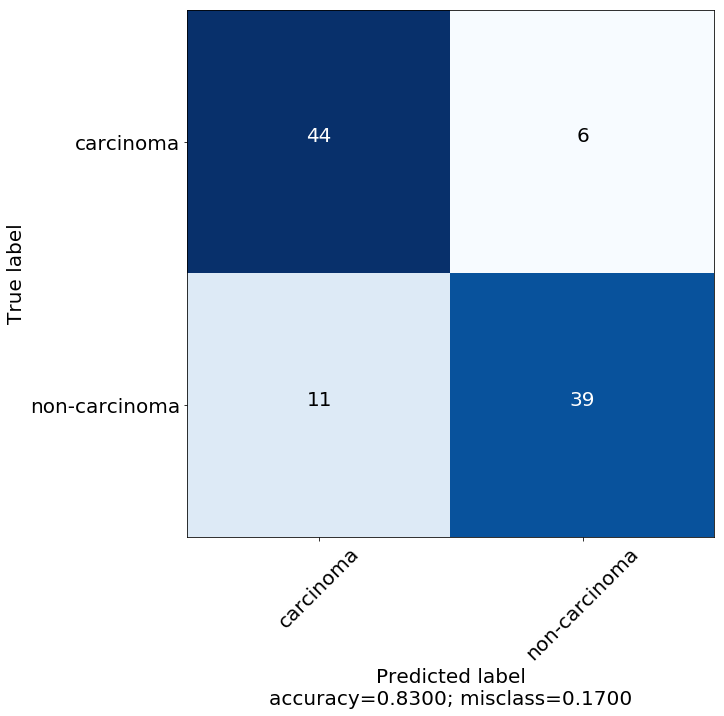

In [21]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[44  6]
 [11 39]]
               precision    recall  f1-score   support

    carcinoma       0.80      0.88      0.84        50
non-carcinoma       0.87      0.78      0.82        50

  avg / total       0.83      0.83      0.83       100



In [23]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  80.0
Specificity :  86.66666666666667


In [24]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.8333333333333334


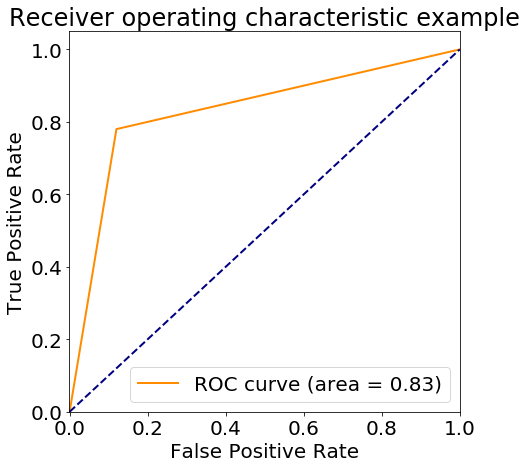

In [25]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [26]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

100/100 [==============================] - 0s 0us/step


In [27]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [28]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

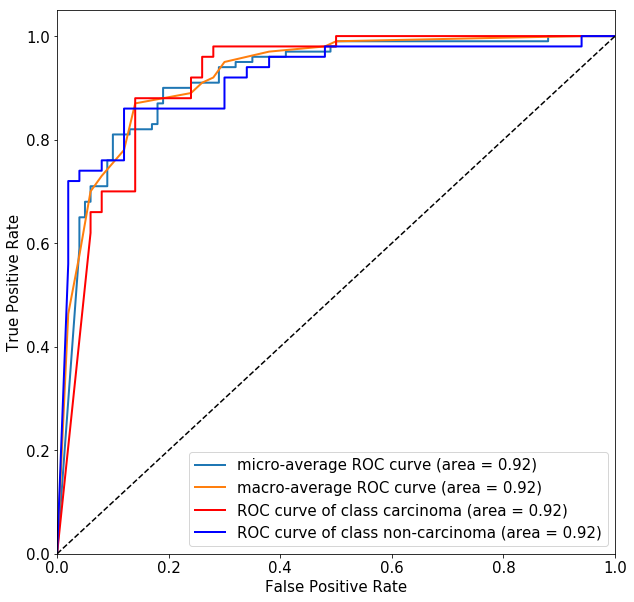

In [29]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [30]:
tn, fp, fn, tp = cm.ravel()

In [31]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.83
Precision: 0.8666666666666667
Recall: 0.78
tp: 39
fp: 6
tn: 44
fn: 11


In [32]:
print('F1 score:', f1_score(y_true, y_pred))

F1 score: 0.8210526315789474


In [33]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.8210526315789475


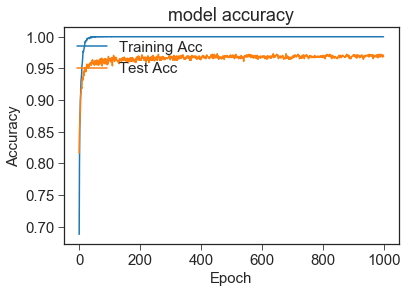

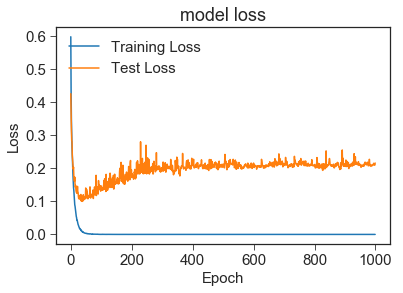

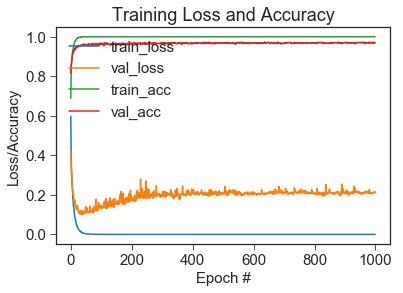

In [34]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")